In [ ]:
!pip install --upgrade tensorflow==2.17.0
import tensorflow
print(tensorflow.version.VERSION)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import os
import shutil
import random

2.17.0


In [ ]:
import tensorflow
print(tensorflow.version.VERSION)
print(tensorflow.config.list_physical_devices('GPU'))

2.17.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def clone_and_prepare_dataset(github_repo='https://github.com/laxmimerit/dog-cat-full-dataset.git'):
    # Remove existing dataset directory if it exists
    if os.path.exists('dog-cat-full-dataset'):
        print("Removing existing directory 'dog-cat-full-dataset'...")
        shutil.rmtree('dog-cat-full-dataset')

    # Remove existing class directories if they exist
    for subset in ['train', 'validation', 'test']:
        if os.path.exists(subset):
            print(f"Removing existing '{subset}' directory...")
            shutil.rmtree(subset)

    print("Cloning the repository...")
    !git clone {github_repo}

    base_dir = 'dog-cat-full-dataset/data'
    print(f"Checking contents of base directory: {base_dir}")

    if os.path.exists(base_dir):
        print("Files in base directory:")
        print(os.listdir(base_dir))
    else:
        print(f"Directory {base_dir} does not exist.")
        return

    # Create target directories
    os.makedirs('train/cats', exist_ok=True)
    os.makedirs('train/dogs', exist_ok=True)
    os.makedirs('validation/cats', exist_ok=True)
    os.makedirs('validation/dogs', exist_ok=True)
    os.makedirs('test/cats', exist_ok=True)
    os.makedirs('test/dogs', exist_ok=True)

    cat_images = []
    dog_images = []

    for label in ['train', 'test']:
        for subdir in ['cats', 'dogs']:
            image_dir = os.path.join(base_dir, label, subdir)
            if os.path.exists(image_dir):
                images = os.listdir(image_dir)
                for img in images:
                    if subdir == 'cats':
                        cat_images.append(os.path.join(image_dir, img))
                    elif subdir == 'dogs':
                        dog_images.append(os.path.join(image_dir, img))

    print(f"Found {len(cat_images)} cat images and {len(dog_images)} dog images.")

    # Shuffle the lists to ensure randomness
    random.shuffle(cat_images)
    random.shuffle(dog_images)

    # Move images to train, validation, and test sets
    for i, img in enumerate(cat_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/cats', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/cats', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/cats', os.path.basename(img)))

    for i, img in enumerate(dog_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/dogs', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/dogs', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/dogs', os.path.basename(img)))

    print('Dataset cloned and organized into train, validation, and test sets!')

# Call the function to clone and prepare the dataset
clone_and_prepare_dataset()


Cloning the repository...
Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25033, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 25033 (delta 0), reused 4 (delta 0), pack-reused 25027 (from 1)
Receiving objects: 100% (25033/25033), 541.85 MiB | 25.46 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (24990/24990), done.
Checking contents of base directory: dog-cat-full-dataset/data
Files in base directory:
['test', 'train']
Found 12500 cat images and 12489 dog images.
Dataset cloned and organized into train, validation, and test sets!


In [ ]:
def count_images_in_directories(base_path='/content'):
    directory_structure = {
        'train': {'cats': 0, 'dogs': 0},
        'validation': {'cats': 0, 'dogs': 0},
        'test': {'cats': 0, 'dogs': 0},
    }

    for set_type in directory_structure.keys():
        for class_type in directory_structure[set_type].keys():
            dir_path = os.path.join(base_path, set_type, class_type)
            if os.path.exists(dir_path):
                directory_structure[set_type][class_type] = len([f for f in os.listdir(dir_path) if f.endswith(('jpg', 'jpeg', 'png'))])
            else:
                print(f"Directory {dir_path} does not exist.")

    return directory_structure

def print_image_counts(image_counts):
    print("Image counts in each directory:")
    for set_type, classes in image_counts.items():
        print(f"\n{set_type.capitalize()} Set:")
        for class_type, count in classes.items():
            print(f"  {class_type.capitalize()}: {count} images")

image_counts = count_images_in_directories(base_path='/content')
print_image_counts(image_counts)

Image counts in each directory:

Train Set:
  Cats: 1000 images
  Dogs: 1000 images

Validation Set:
  Cats: 500 images
  Dogs: 500 images

Test Set:
  Cats: 500 images
  Dogs: 500 images


In [ ]:
train_dataset = image_dataset_from_directory(
    '/content/train/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

val_dataset = image_dataset_from_directory(
    '/content/validation/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

test_dataset = image_dataset_from_directory(
    '/content/test/',  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


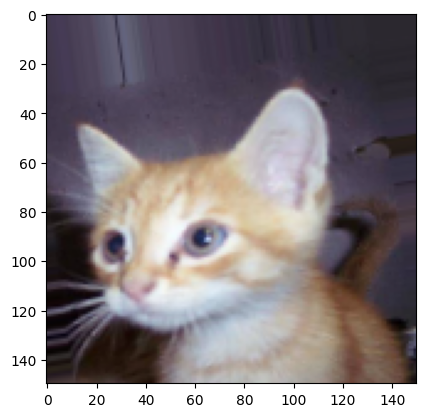

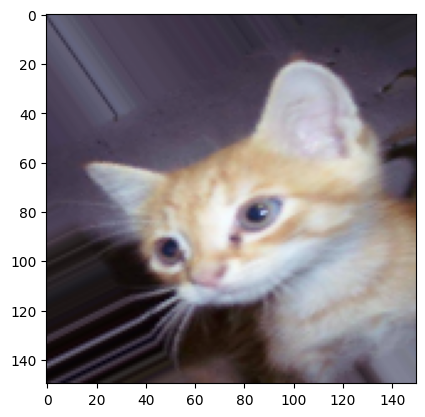

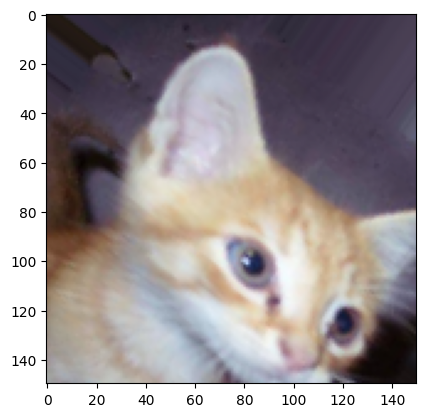

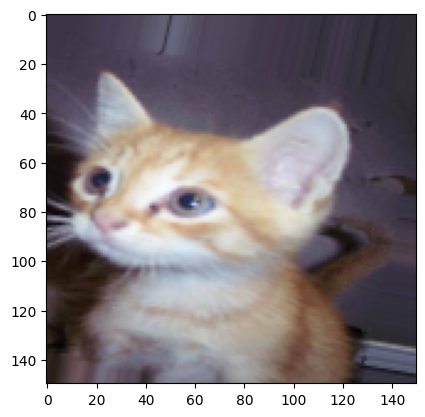

In [ ]:
train_cats_dir = r"/content/train/cats"
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

datagen = image.ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation((-0.2, 0.2)),
    layers.RandomZoom((0.3, 0.3)),
    layers.RandomTranslation(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
    layers.RandomContrast(0.5)
])

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(150,150,3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.build((None, 150, 150, 3))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4932 - loss: 0.6942 - val_accuracy: 0.5470 - val_loss: 0.6909
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5318 - loss: 0.6917 - val_accuracy: 0.5670 - val_loss: 0.6901
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5326 - loss: 0.6918 - val_accuracy: 0.5560 - val_loss: 0.6837
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5325 - loss: 0.6893 - val_accuracy: 0.5660 - val_loss: 0.6839
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5612 - loss: 0.6839 - val_accuracy: 0.5840 - val_loss: 0.6758
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5693 - loss: 0.6819 - val_accuracy: 0.6400 - val_loss: 0.6546
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5763 - loss: 0.6712 - val_accuracy: 0.6170 - val_loss: 0.6467
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5975 - loss: 0.6617 -

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

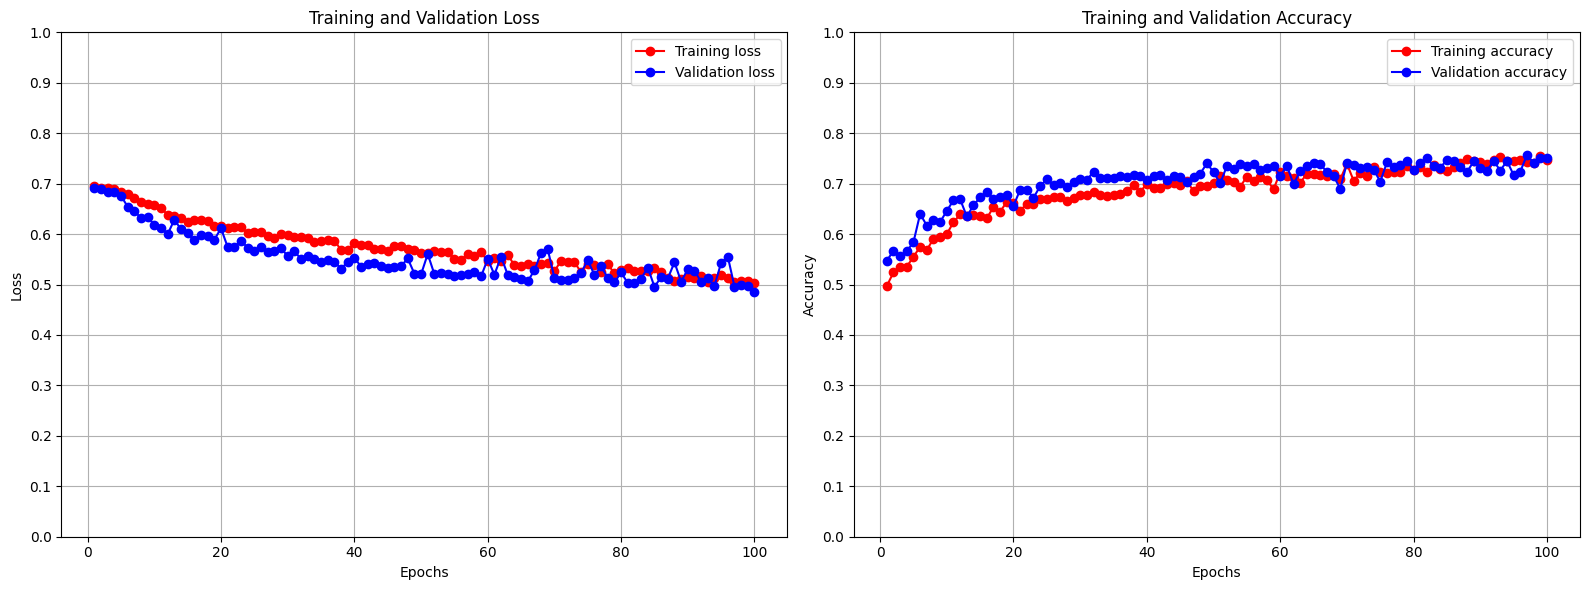

In [ ]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('test_loss', test_loss)
print('test_acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7812 - loss: 0.4623
test_loss 0.48036661744117737
test_acc: 0.7720000147819519


In [ ]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.5),  # Random rotation in radians
    layers.RandomZoom(0.3),      # Random zoom
    layers.RandomTranslation(0.3, 0.3)  # Random translation
])

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(150,150,3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.build((None, 150, 150, 3))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

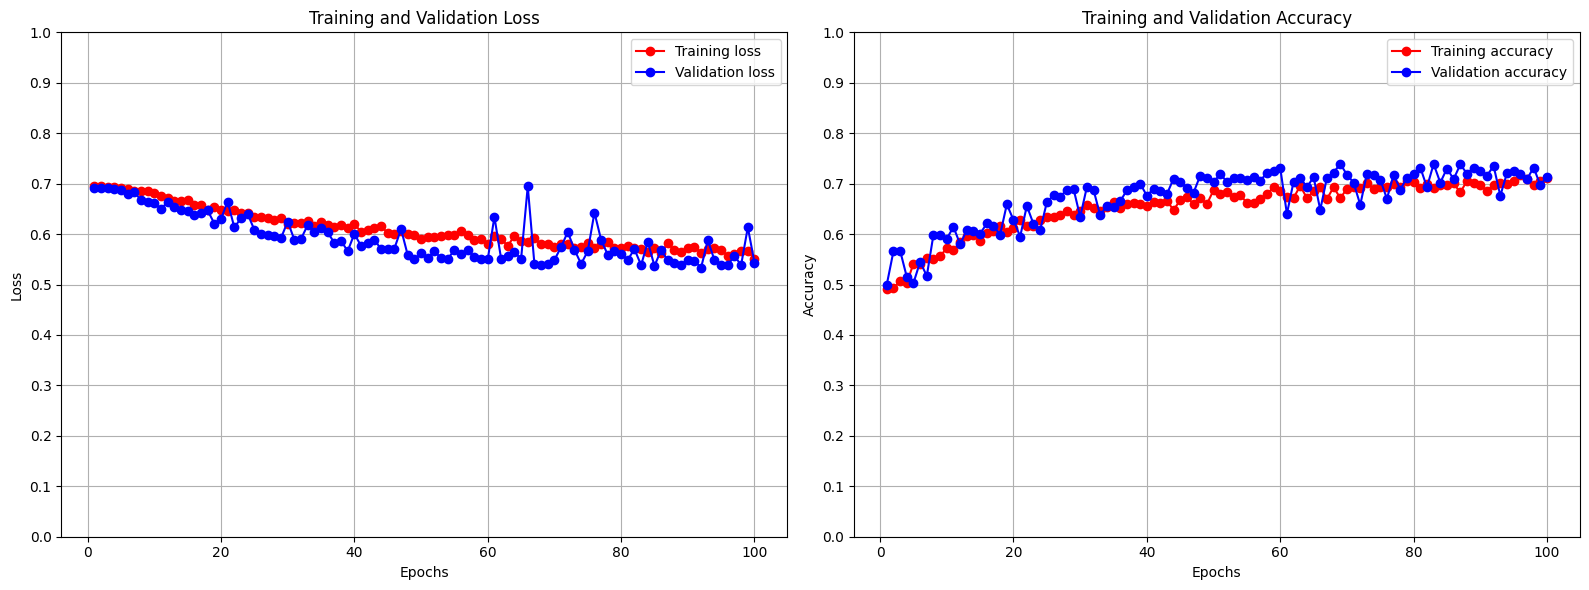

In [ ]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('test_loss', test_loss)
print('test_acc:', test_acc)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7321 - loss: 0.5512
test_loss 0.5606542825698853
test_acc: 0.7250000238418579


In [ ]:
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(150,150,3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.7))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.build((None, 150, 150, 3))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5263 - loss: 0.6923 - val_accuracy: 0.4990 - val_loss: 0.6942
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5202 - loss: 0.6912 - val_accuracy: 0.5590 - val_loss: 0.6817
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5581 - loss: 0.6799 - val_accuracy: 0.6120 - val_loss: 0.6653
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6101 - loss: 0.6614 - val_accuracy: 0.5950 - val_loss: 0.6506
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6264 - loss: 0.6515 - val_accuracy: 0.6380 - val_loss: 0.6320
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.6356 - loss: 0.6348 - val_accuracy: 0.5890 - val_loss: 0.6548
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6417 - loss: 0.6254 - val_accuracy: 0.6720 - val_loss: 0.6053
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6709 - loss: 0.6089 - 